In [ ]:
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import torch 
import pandas as pd 
import numpy as np

from collections import Counter
import pickle

/home/marcbr/miniconda3/envs/nats/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import os 

In [ ]:
import os 
os.chdir('../')


In [5]:
from notebooks.utils import VAEDataset


In [6]:
def list_folders_by_newest(path):
    # Get only subdirectories
    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    
    # Sort by modification time (most recent first)
    folders_sorted = sorted(
        folders,
        key=lambda x: os.path.getmtime(os.path.join(path, x)),
        reverse=True
    )
    return folders_sorted

In [7]:
optimism_dataset = VAEDataset(
        data_folder = 'data/simulations/qwen2.5:7b_2025_07_27/',
        file =  'optimism_interventions_1000.csv', 
        text_column="text")

100%|██████████| 83/83 [00:08<00:00,  9.55it/s]


In [8]:
list_folders_by_newest('models/vae_model/optimism')

['VAE_training_2025-01-02_18-39-47',
 'VAE_training_2024-11-21_23-16-48',
 'VAE_training_2024-11-19_12-19-53']

In [8]:
optimism_vae = VAE.load_from_folder(
    'models/vae_model/optimism/VAE_training_2025-01-02_18-39-47/final_model'
)

In [ ]:
optimism_dataset.data.head()

,text,rating,stepsprevday,currloc
0,"You took more than 15,000 steps yesterday. Kee...",0,"more than 15,000",home
1,Yesterday was a good day for stepping. Maybe t...,1,"more than 15,000",home
2,It's great that you hit your step goal again. ...,2,"more than 15,000",home
3,"Taking over 15,000 steps in one day is no smal...",3,"more than 15,000",home
4,Your hard work is paying off - you're consiste...,4,"more than 15,000",home


In [10]:
optimism_vae.eval()
with torch.no_grad():
    embed = optimism_vae.encoder(optimism_dataset.text_embeddings)

In [11]:
optimism_dataset.data['embedding'] = embed['embedding'].numpy() 


In [12]:
save_folder = './results/plots/supplement/non_experiment_plots'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


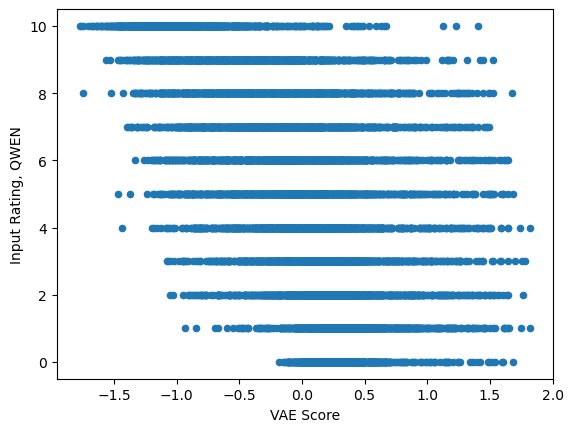

In [ ]:
ax = optimism_dataset.data.plot.scatter(x='embedding', y='rating')
ax.set_xlabel("VAE Score")
ax.set_ylabel("Input Rating, QWEN")
fig = ax.get_figure()
filename = "vae_score_vs_rating_outliers.pckl"
fig.savefig(os.path.join(save_folder, filename), bbox_inches="tight")
with open(os.path.join(save_folder, filename), "wb") as f:
    pickle.dump(fig, f)


In [15]:
optimism_dataset.data.loc[optimism_dataset.data['embedding'] > 2, ['text', 'embedding']]

,text,embedding
2803,"It's not just about yesterday or today, though...",2.069258
6264,It seems like a lot of people find that gettin...,2.053869
21252,\n,3.966808
21253,\n,3.966808
21274,\n,3.966808
...,...,...
21907,\n,3.966808
21908,\n,3.966808
21909,\n,3.966808
21910,\n,3.966808


In [41]:
lowest_rating = optimism_dataset.data.loc[optimism_dataset.data.rating==1]
lowest_rating.loc[lowest_rating['embedding'].idxmin(), 'text']

"Tomorrow is a brand new day, and that means you've got another chance to hit 10,000 steps - make it happen!"

In [54]:
lowest_rating.loc[lowest_rating['embedding'] < -.5, ['text', 'embedding']].iloc[8]['text']

"You're on a roll after yesterday's success - keep up the pace and see where it takes you!"

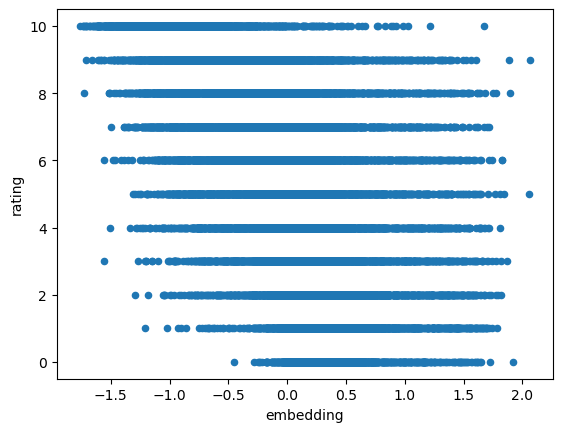

In [18]:
optimism_dataset.data.loc[optimism_dataset.data.embedding < 3].plot.scatter(x='embedding', y='rating')
ax.set_xlabel("VAE Score")
ax.set_ylabel("Input Rating")
fig = ax.get_figure()
filename = "vae_score_vs_rating.pckl"
# fig.savefig(os.path.join(save_folder, filename), bbox_inches="tight")
with open(os.path.join(save_folder, filename), "wb") as f:
    pickle.dump(fig, f)